# Lab 3

## Reading CSV files

In [5]:
import pandas as pd

training_mice = pd.read_csv('./pw3_data/EEG_mouse_data_1.csv')
training_mice2 = pd.read_csv('./pw3_data/EEG_mouse_data_2.csv')

training_data = pd.concat([training_mice, training_mice2], ignore_index=True)


## Choosing features

First idea use ANOVA correlation coefficient for feature selection

In [6]:
from sklearn.feature_selection import f_classif


target = training_data.iloc[:, 0]  # Assuming the first column is the class
features = training_data.iloc[:, 1:]  # Rest of the columns are features

#Calculated the ANOVA correlation coefficient for each feature
anova_corr_coef, _ = f_classif(features, target)
result = pd.DataFrame({'Feature': features.columns, 'anova_coeff': anova_corr_coef})
sorted_result = result.sort_values(by=['anova_coeff'],ascending=False)
first_50 = sorted_result[:50]["Feature"].to_list()

input_training_mice = training_data[first_50]


print(input_training_mice.head())


   amplitude_around_4_Hertz  amplitude_around_3_Hertz  \
0                  0.000014                  0.000013   
1                  0.000015                  0.000011   
2                  0.000019                  0.000034   
3                  0.000016                  0.000044   
4                  0.000017                  0.000012   

   amplitude_around_2_Hertz  amplitude_around_8_Hertz  \
0                  0.000014                  0.000011   
1                  0.000010                  0.000011   
2                  0.000077                  0.000004   
3                  0.000031                  0.000007   
4                  0.000011                  0.000025   

   amplitude_around_14_Hertz  amplitude_around_15_Hertz  \
0                   0.000003               1.268680e-06   
1                   0.000003               1.077152e-06   
2                   0.000001               1.294509e-06   
3                   0.000002               2.171980e-07   
4                  

## Normalize and encode data

balance data and fit and transform all column except "state"  with StandardScaler

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# Encode the state
state = pd.DataFrame(target.to_frame())
encoder.fit(state)

output_training_mice = encoder.transform(target.to_frame())



for column in input_training_mice:
    column_data = input_training_mice[column].to_frame()
    scaler.fit(column_data)
    input_training_mice[column] = scaler.transform(column_data)
    

print(output_training_mice.head)
print(input_training_mice.head)



       state_n  state_r  state_w
0          1.0      0.0      0.0
1          1.0      0.0      0.0
2          1.0      0.0      0.0
3          0.0      0.0      1.0
4          0.0      0.0      1.0
...        ...      ...      ...
40858      0.0      0.0      1.0
40859      0.0      0.0      1.0
40860      0.0      0.0      1.0
40861      0.0      0.0      1.0
40862      0.0      0.0      1.0

[40863 rows x 3 columns]


C:\Users\Eyrag\AppData\Local\Temp\ipykernel_16340\828011036.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_training_mice[column] = scaler.transform(column_data)
C:\Users\Eyrag\AppData\Local\Temp\ipykernel_16340\828011036.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_training_mice[column] = scaler.transform(column_data)
C:\Users\Eyrag\AppData\Local\Temp\ipykernel_16340\828011036.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

## Create model and fold

In [8]:
import keras
import keras_tuner as kt
from keras import layers
from sklearn.model_selection import KFold

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

def create_model():

  mlp = keras.Sequential()
  mlp.add(layers.Input(shape=(50,)))
  mlp.add(layers.Dense(8, activation="leaky_relu"))
  
  mlp.add(layers.Dense(3, activation="softmax"))
  
  learning_rate = 0.001
 
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
 

  mlp.compile(
      optimizer=optimizer,
      loss="categorical_crossentropy",
      metrics=[keras.metrics.F1Score(average="weighted")]
  )

  return mlp
#Create Keras tuner instance
# tuner = kt.GridSearch(
#     create_model,
#     objective= kt.Objective("val_f1_score", direction="max"),
#     overwrite=True,
#     directory="./tuning",

# )


mlp = create_model()
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435 (1.70 KB)

 Trainable params: 435 (1.70 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Idea 2, SMOTE (Synthetic Minority Over-sampling Technique ) to balance classes observations

In [9]:
import numpy as np
from imblearn.over_sampling import SMOTE
history_list = []
trained_mlp = []
smote = SMOTE()

for i, (train_index, test_index) in enumerate(kf.split(input_training_mice)): 
  
  x_train, x_test = input_training_mice.iloc[train_index], input_training_mice.iloc[test_index]
  y_train, y_test = np.array(output_training_mice)[train_index],np.array(output_training_mice)[test_index]
  #Code that enable keras tuner on first fold
  # if(i == 0):
  #   tuner.search(
  #     x=x_train, y=y_train,
  #     validation_data=(x_test, y_test),
  #     epochs=100,
  #     callbacks=[keras.callbacks.TensorBoard("./tmp/tb_logs")]
  #   )
  #   tuner.results_summary()
  # else:
  #best_hps = tuner.get_best_hyperparameters(1)
  mlp = create_model()

  #SMOTE disabled (trying to balance n-rem data)
  #x_train, y_train = smote.fit_resample(x_train, y_train)
    
  history = mlp.fit(
      x=x_train, y=y_train,
      validation_data=(x_test, y_test),
      epochs=100
  )
  history_list.append(history)
  trained_mlp.append(mlp)

Epoch 1/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.7230 - loss: 0.6480 - val_f1_score: 0.8626 - val_loss: 0.3217
Epoch 2/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - f1_score: 0.8757 - loss: 0.3028 - val_f1_score: 0.8842 - val_loss: 0.2996
Epoch 3/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - f1_score: 0.8915 - loss: 0.2850 - val_f1_score: 0.8889 - val_loss: 0.2932
Epoch 4/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - f1_score: 0.8944 - loss: 0.2780 - val_f1_score: 0.8896 - val_loss: 0.2901
Epoch 5/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - f1_score: 0.8948 - loss: 0.2740 - val_f1_score: 0.8901 - val_loss: 0.2878
Epoch 6/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - f1_score: 0.8953 - loss: 0.2713 - val_f1_score: 0.8904 - val_loss: 0.2862
Epoch 7/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - f1_score: 0.8954 - loss: 0.2693 - val_f1_score: 0.8905 - val_loss: 0.2852
Epoch 8/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - f1_score: 0.8958 - loss: 0.2

## Plot training history

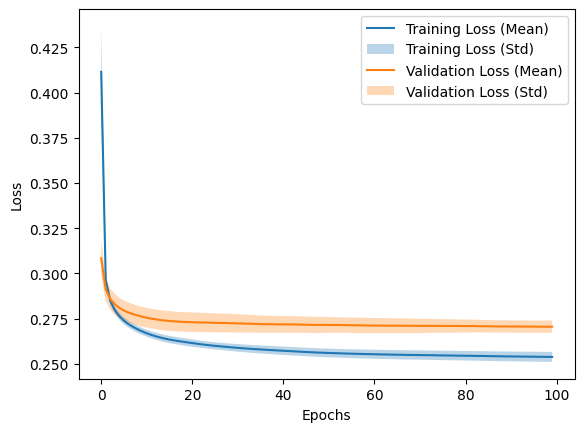

In [ ]:
import matplotlib.pyplot as pl
%matplotlib inline

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

## Performance

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


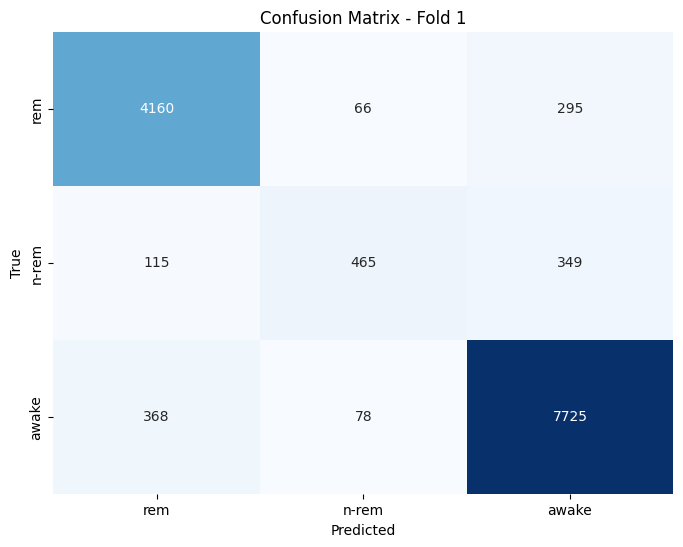

F1 Score - Fold 1: 0.9029360017044084
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


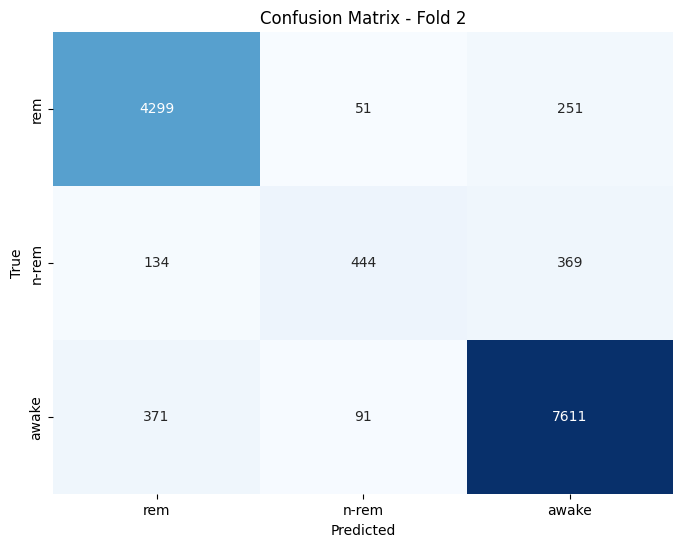

F1 Score - Fold 2: 0.9024306428239571
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step


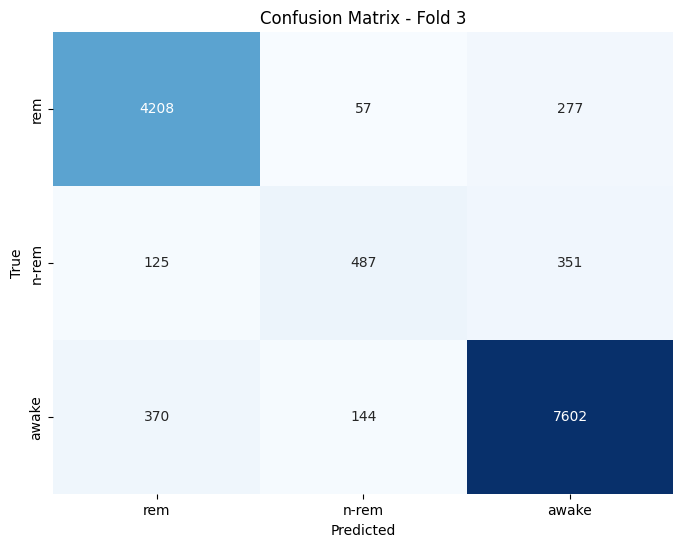

F1 Score - Fold 3: 0.899480082637145


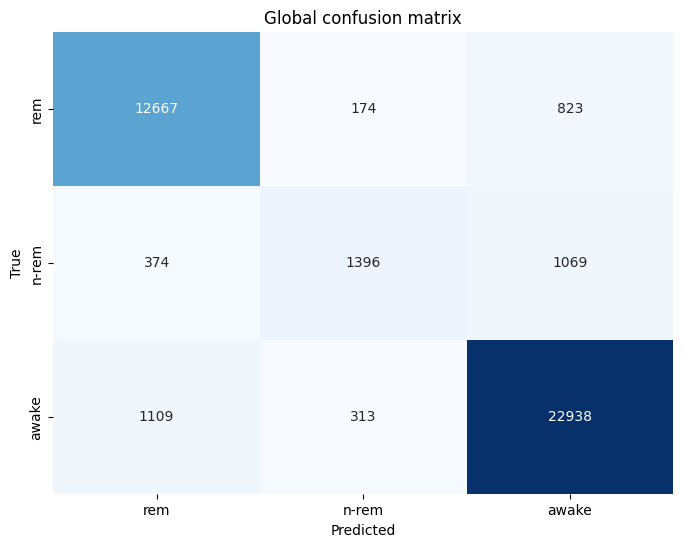

Mean F1 Score across all folds: 0.9016155757218369


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["rem","n-rem","awake"], yticklabels=["rem","n-rem", "awake"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(input_training_mice)):
    # Evaluate the trained model on the test fold
    predictions = trained_mlp[i-1].predict(input_training_mice.loc[test_index])
    true_labels = np.array(output_training_mice)[test_index]
    
    max_predictions = []
    max_true_labels = []
    for prediction in predictions:
        max_predictions.append(np.argmax(prediction))
        
    for true_label in true_labels:
        max_true_labels.append(np.argmax(true_label))
    
    # Compute confusion matrix
    cm = confusion_matrix(max_true_labels, max_predictions)
    mean_confusion_matrix += confusion_matrix(max_true_labels, max_predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(max_true_labels, max_predictions, average='weighted')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

## Prédiction

In [ ]:
testing_mice = pd.read_csv('./pw3_data/EEG_mouse_data_test.csv')

testing_mice = testing_mice[first_50]

for column in testing_mice:
    column_data = testing_mice[column].to_frame()
    scaler.fit(column_data)
    testing_mice[column] = scaler.transform(column_data)

predictions = trained_mlp[0].predict(testing_mice)
final_predictions = []
for prediction in predictions:
    index  = np.argmax(prediction)
    if index == 0:
        final_predictions.append('n')
    elif index == 1:
        final_predictions.append('r')
    else:
        final_predictions.append('w')

print(final_predictions)